<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/contact_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grafos de contacto

En este cuaderno de Jupyter Notebook se realiza un análisis de los residuos alostéricos de dos GPCR: receptor A2A de adenosina y receptor beta-2 adrenérgico. Ambos son receptores cuyo mecanismo de transmisión de la señal se basa en el alosterismo.

En este cuaderno se estudian residuos de interés para la transmisión de la señal alostérica usando el análisis matemático propio de la teoría de grafos. junto con los estudios de atención generados con ESM-2. Por tanto, para generar los grafos es fundamental tener los datos de atención en formato CSV obtenidos al ejecutar los scripts analyze_a2a.py y analyze_adrb2.py

Cada nodo del grafo representa el carbono alfa del aminoácido correspondiente y dos nodos se unen si la distancia entre los carbonos alfa se encuentra entre los 4 y los 8 angstroms. Además, el nodo puede tener un tamaño u otro en función de la medida de centralidad de intermediación, y su color varía en función de la atención.

In [1]:
# Instalación de librerías necesarias para el análisis:
# igraph para la construcción de los grafos de proteínas
# biopython para extraer los datos de las coordenadas de los átomos de la pro-
# teína en formato .cif

!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.0 MB/s eta 0:00:00


# Descargar la estructura el formato .cif para hacer el grafo

Para esta parte del análisis es esencial tener la posición de los residuos en la secuencia de la proteína. Sin embargo, en los archivos .pdb no suele ser común que se almacene las posiciones de esa manera, sino que lo hace en el indexado auth, que se corresponde con el indexado de la estructura tridimensional. Para corregir esto trabajamos con el formato .cif, que si recoge la posición del aminoácido en la secuencia lineal.

In [2]:
# Al definir esta función podemos usarla para descargar archivos .mmCIF desde
# el RCSB PDB para trabajar con ellos con más facilidad
import os
import requests

def download_mmcif(pdb_id, save_dir="mmcif_files"):
    """
    Descarga el archivo .mmCIF para el PDB ID dado desde el servidor de RCSB.

    Args:
        pdb_id (str): Identificador de la proteína en el PDB (e.g., "2YDO").
        save_dir (str): Carpeta donde se guardará el archivo.

    Returns:
        str: Ruta al archivo descargado.
    """
    pdb_id = pdb_id.lower()
    url = f"https://files.rcsb.org/download/{pdb_id}.cif"

    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{pdb_id}.cif")

    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, "w") as f:
            f.write(response.text)
        print(f"✅ Archivo descargado: {file_path}")
        return file_path
    else:
        raise ValueError(f"No se pudo descargar el archivo para PDB ID '{pdb_id}'. Código de estado: {response.status_code}")


Estas son las cuatro estructuras con las que trabajamos. Con este bloque se descargan sus respectivos archivos en formato .cif

In [3]:
# Descarga los archivos .cif de las estructuras con las que vamos a trabajar.

pdbs = ["2YDO", "2R4R"]
for pdb in pdbs:
  download_mmcif(pdb)

✅ Archivo descargado: mmcif_files/2ydo.cif
✅ Archivo descargado: mmcif_files/2r4r.cif


# PSN de atención

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 2R4R: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G_4ldo"]

In [4]:
# Diccionario de sitios importantes

sites = {
    "A2A_adenosine": [169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi": [203, 204, 207, 293, 296, 308],
    "beta2AR_G":[130, 131, 139, 141],
    }

## PSN de 2YDO

<ipython-input-5-79cf42fa7b39>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


   Leu26 | Betweenness: 3368.2305
  Ile302 | Betweenness: 3150.4972
   Val84 | Betweenness: 2923.3737
  Phe299 | Betweenness: 2835.9560
   Val27 | Betweenness: 2785.0497
   Val55 | Betweenness: 2783.0570
  Val282 | Betweenness: 2561.9771
   Ala81 | Betweenness: 2471.5008
   Asn24 | Betweenness: 2449.4384
  Val307 | Betweenness: 2405.3482
  Ser234 | Betweenness: 2313.0537
  Val172 | Betweenness: 2289.3266
  Ile303 | Betweenness: 2281.5055
  His278 | Betweenness: 2262.3383
   Ala49 | Betweenness: 2235.0003
   Ile92 | Betweenness: 2112.5109
   Ala48 | Betweenness: 2111.0846
   Leu95 | Betweenness: 2080.3391
  Asn284 | Betweenness: 2063.3066
  Pro285 | Betweenness: 2055.4818
   Ser91 | Betweenness: 2006.5858
  Met177 | Betweenness: 1988.5704
  Glu312 | Betweenness: 1970.7628
   Ala99 | Betweenness: 1778.0980
   Phe93 | Betweenness: 1747.9499
  Val186 | Betweenness: 1720.7942
   Pro61 | Betweenness: 1717.4433
   Thr88 | Betweenness: 1654.7062
   Ala65 | Betweenness: 1639.4744
  Met193 | Bet

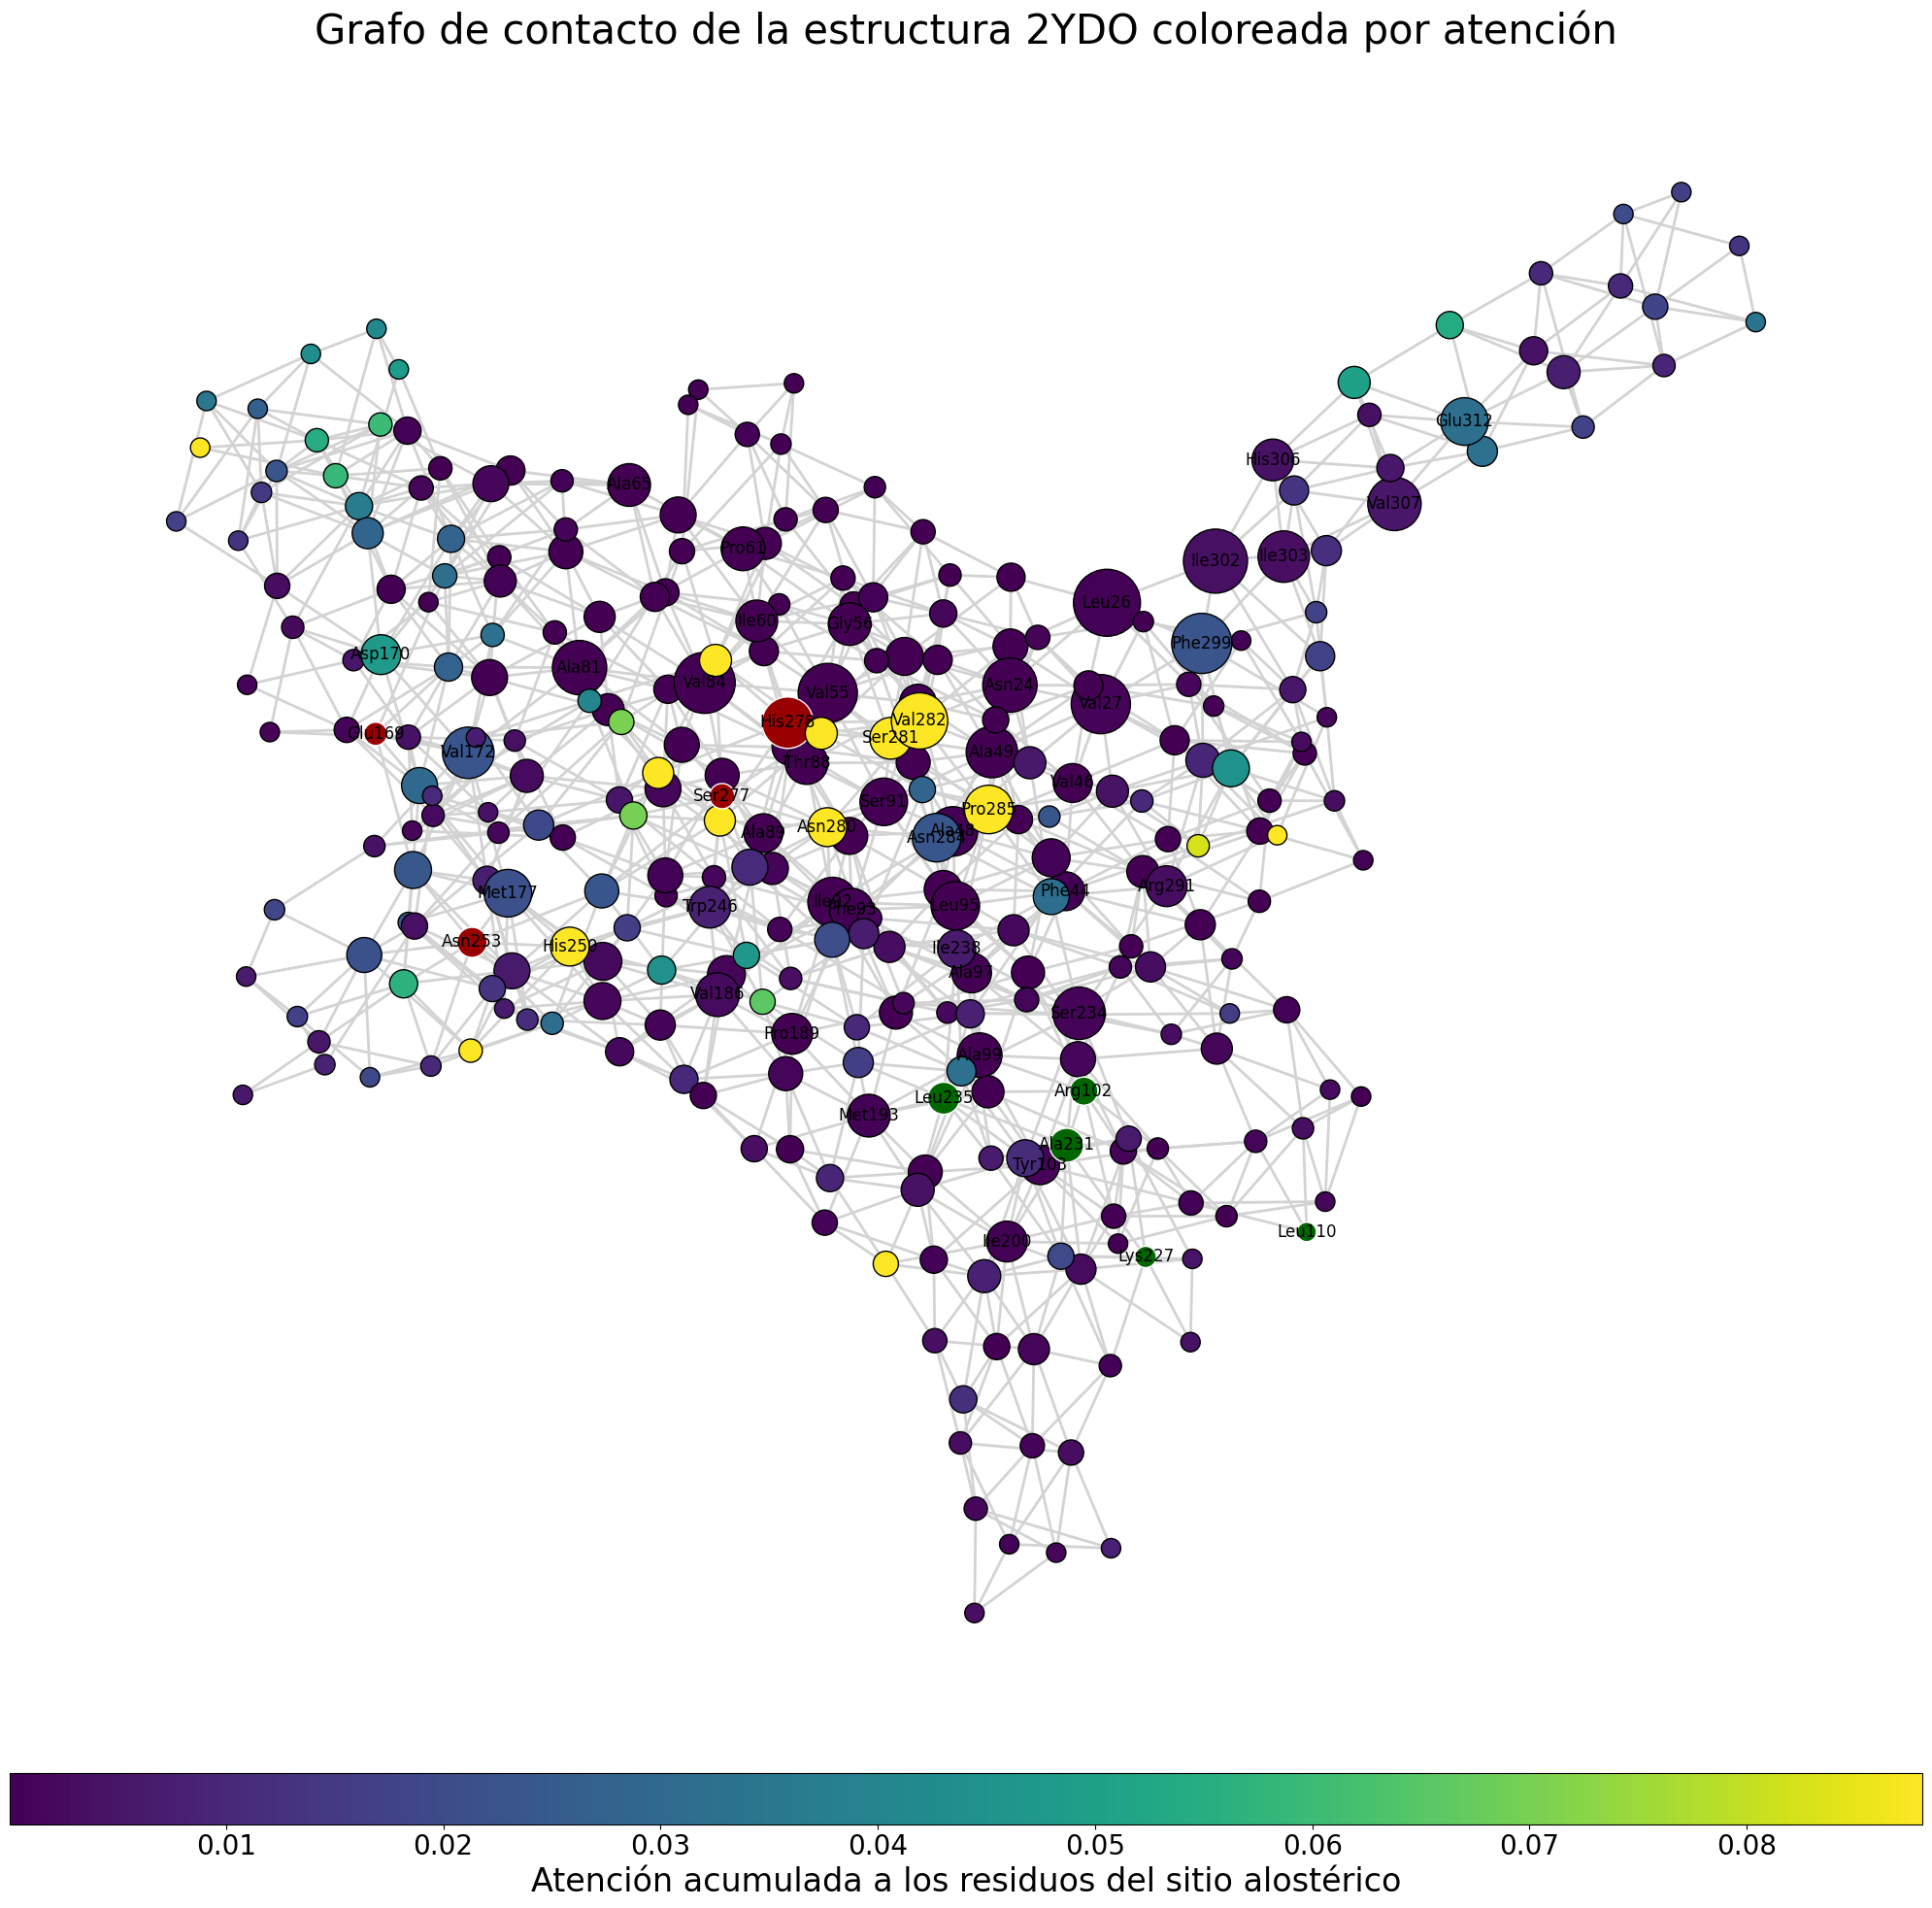

In [5]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import files
import csv

# Configuraciones iniciales
pdb_id = "2YDO"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_a2a.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["A2A_adenosine"]
sitio_O = sites["A2A_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)

# Mapa de atención: nodo (por posición en la cadena) → valor de atención
attention_scores = {}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    att_value = float(row["Accumulated Avg Attention"])
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] = att_value

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0) # Rojo oscuro

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0) # Verde oscuro


# === Calcular el percentil solo para atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)

# Extraer nodos que cumplen solo condición de atención
nodos_destacados = []
for i, node in enumerate(g.vs):
    btw = node["betweenness"]
    if btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta


g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# Etiquetar sitios A y O con borde blanco si existen en el grafo
for resid in sitio_A + sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        g.vs[idx]["frame_color"] = (1, 1, 1) # Blanco

# Ordenar nodos por betweenness
nodos_ordenados = sorted(nodos_destacados, key=lambda x: x["betweenness"], reverse=True)

nodos_high_betweenness = []
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Betweenness: {nodo['betweenness']:.4f}")
    nodos_high_betweenness.append({
        "Residue": nodo["label"],
        "Betweenness Centrality": nodo["betweenness"]
    })

# Guardamos en CSV correctamente
csv_output_path = "residuos_centralidad_a2a.csv"
with open(csv_output_path, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["Residue", "Betweenness Centrality"])
    writer.writeheader()
    writer.writerows(nodos_high_betweenness)

# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(650, 650),
    margin=5,
)

# Barra de color
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.1)  # posición y tamaño
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Atención acumulada a los residuos del sitio alostérico", fontsize=24)
cbar.ax.tick_params(labelsize=20)


plt.suptitle("Grafo de contacto de la estructura 2YDO coloreada por atención", fontsize=30)
plt.tight_layout()
plt.savefig("grafo_atencion_2YDO.pdf", format="pdf", bbox_inches='tight')
plt.show()


## PSN de 2R4R

<ipython-input-6-b41b1e0473f3>:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


  Ile121 | Betweenness: 2256.3514
  Phe282 | Betweenness: 1905.2933
   Asp79 | Betweenness: 1729.1924
  Leu124 | Betweenness: 1564.5194
   Phe71 | Betweenness: 1531.7383
  Thr123 | Betweenness: 1482.3093
   Val54 | Betweenness: 1469.2020
  Ile127 | Betweenness: 1391.0785
   Val67 | Betweenness: 1379.7631
  Leu230 | Betweenness: 1370.9086
  His269 | Betweenness: 1311.3483
  Pro323 | Betweenness: 1149.3190
  Ile233 | Betweenness: 1139.8377
  Cys116 | Betweenness: 1129.4357
  Phe336 | Betweenness: 1126.1671
  Glu338 | Betweenness: 1099.7933
  Met279 | Betweenness: 1092.9923
  Gly320 | Betweenness: 1066.7770
   Asn51 | Betweenness: 1055.1424
  Ala226 | Betweenness: 1051.2868
  Phe223 | Betweenness: 1000.8869
   Leu75 | Betweenness: 988.2491
  Ile278 | Betweenness: 968.6755
  Ile325 | Betweenness: 963.8103
  Arg131 | Betweenness: 921.9505
  Ala271 | Betweenness: 904.3401
  Thr274 | Betweenness: 878.7103
  Leu272 | Betweenness: 872.5196
   Thr73 | Betweenness: 863.9075
  Arg333 | Betweenness

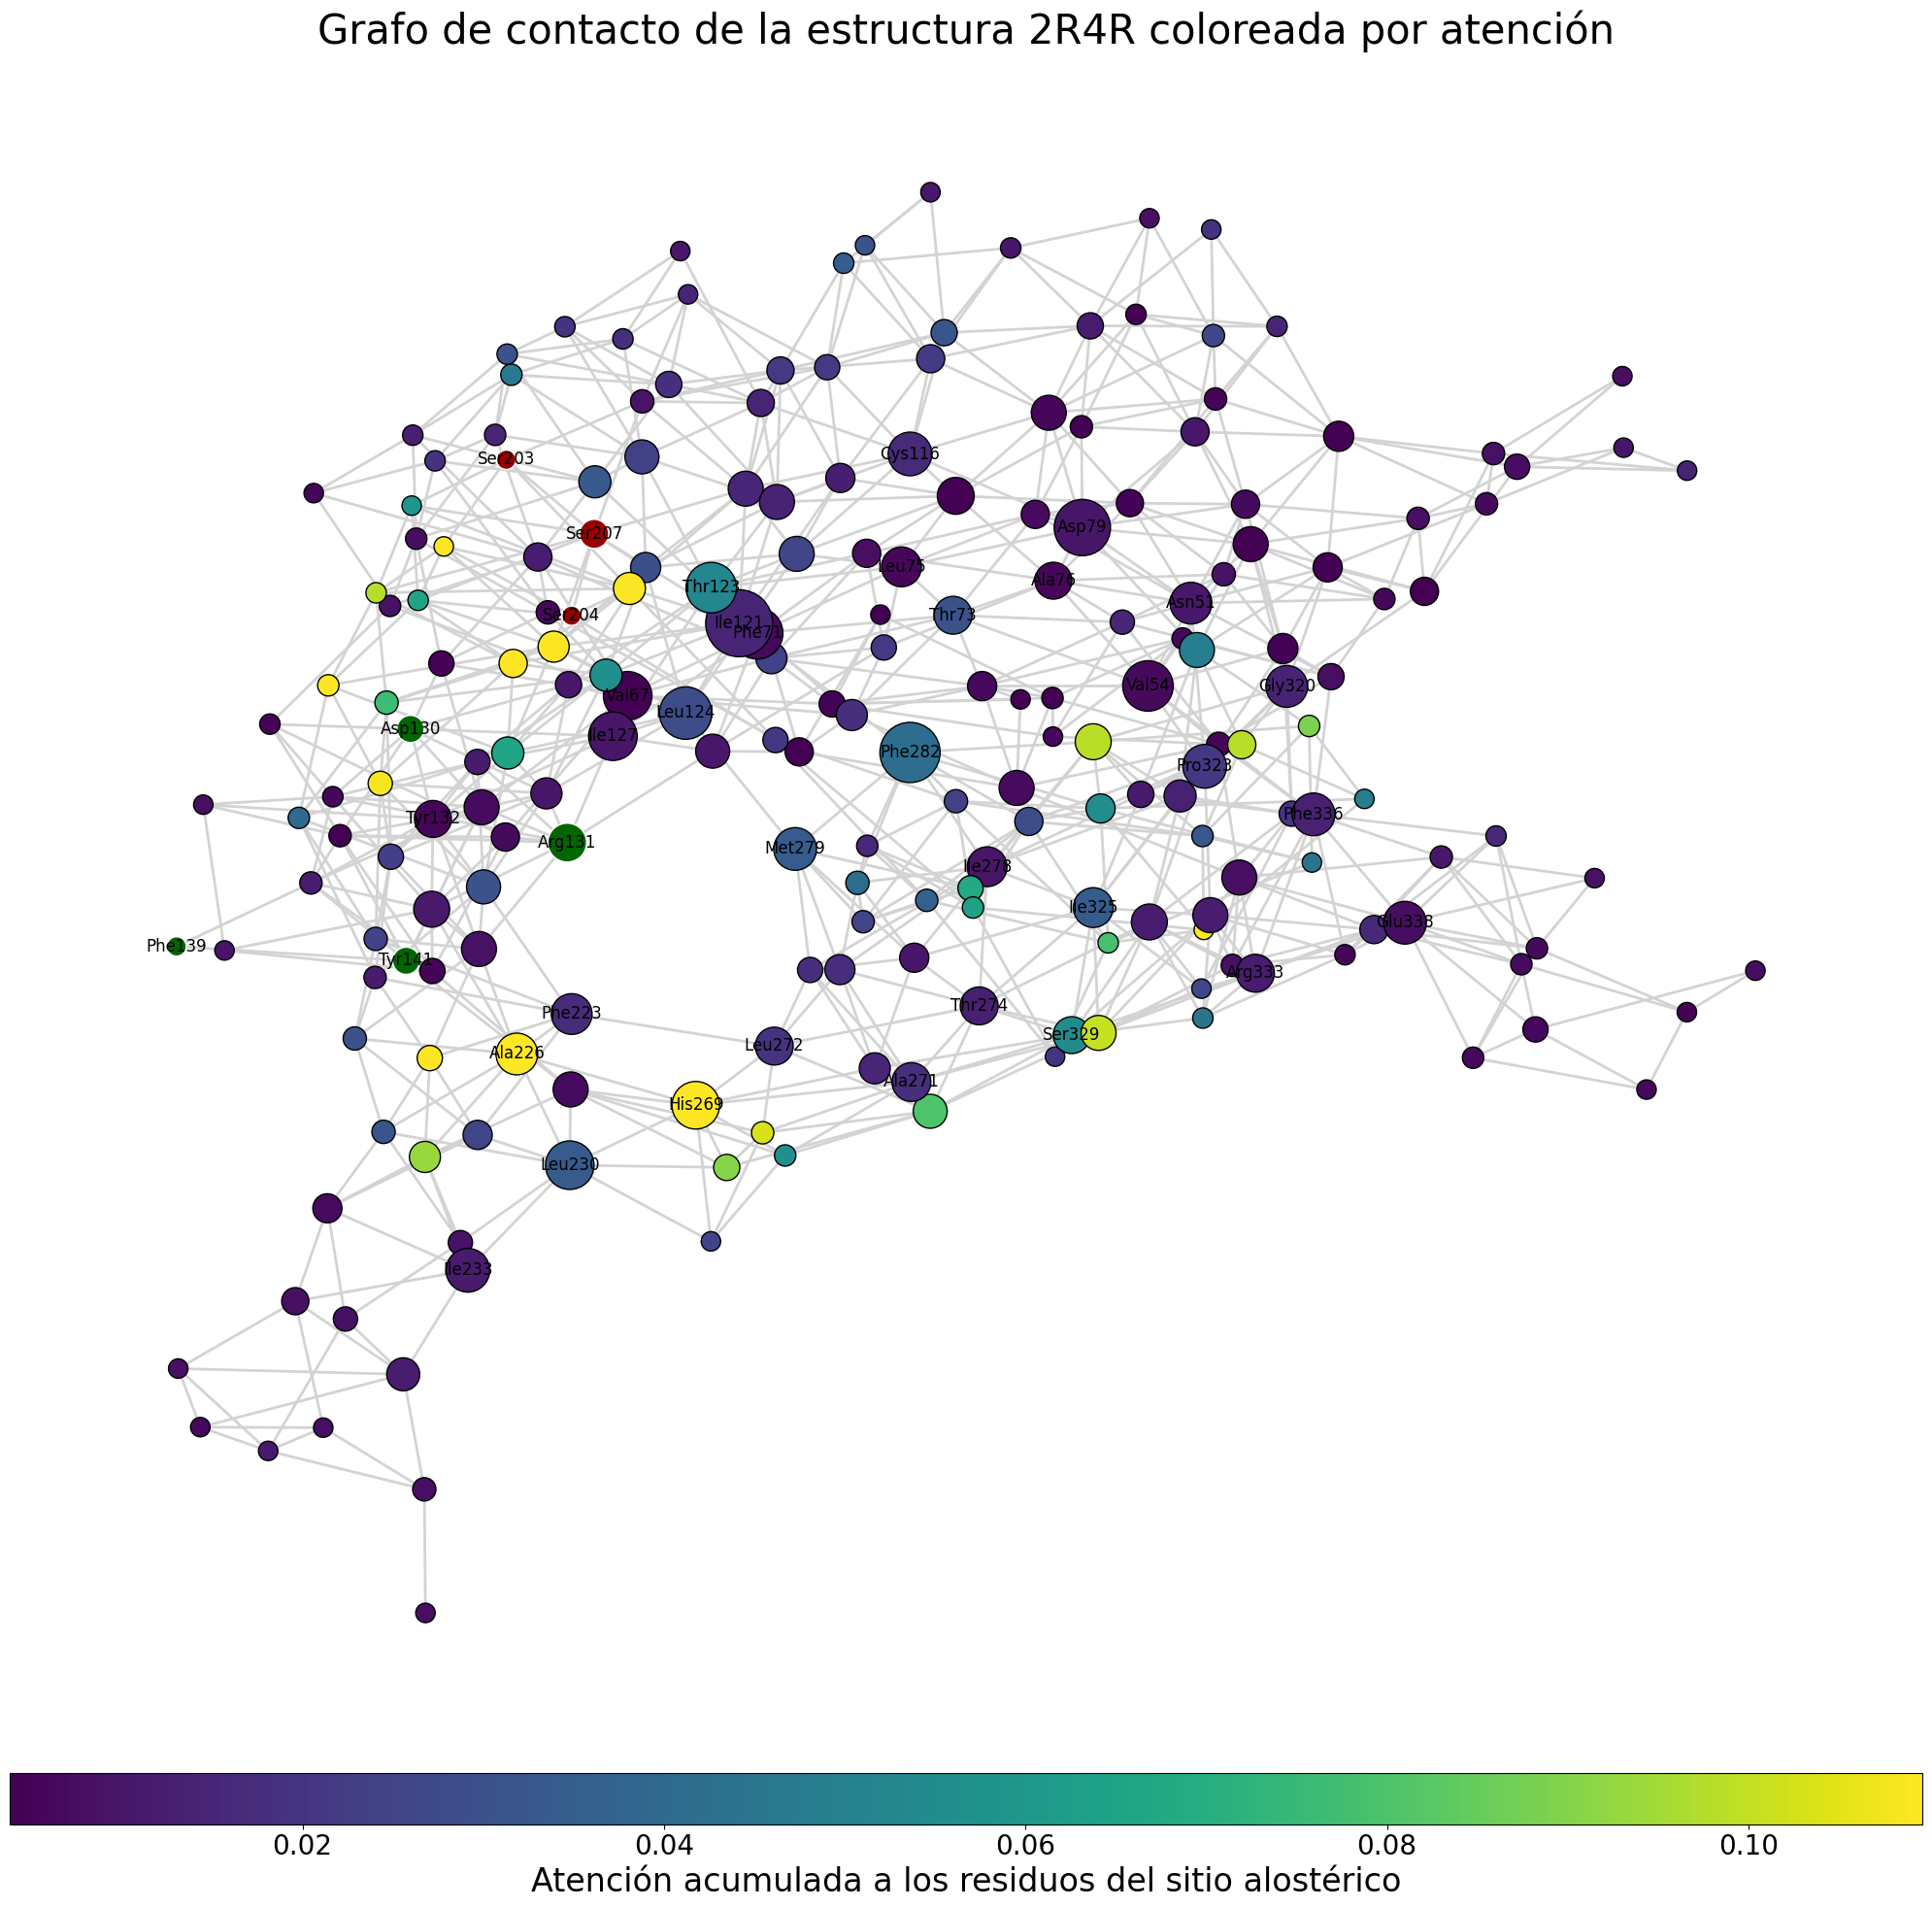

In [6]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import files

# Configuraciones iniciales
pdb_id = "2R4R"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_adrb2.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["beta2AR_epi"]
sitio_O = sites["beta2AR_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)

# Mapa de atención: nodo (por posición en la cadena) → valor de atención
attention_scores = {}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    att_value = float(row["Accumulated Avg Attention"])
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] = att_value

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0) # Rojo oscuro

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0) # Verde oscuro

# === Calcular el percentil solo para atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)

# Extraer nodos que cumplen solo condición de atención
nodos_destacados = []
for i, node in enumerate(g.vs):
    btw = node["betweenness"]
    if btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta


g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# Etiquetar sitios A y O con borde blanco si existen en el grafo
for resid in sitio_A + sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        g.vs[idx]["frame_color"] = (1, 1, 1) # Blanco

# Ordenar nodos por betweenness
nodos_ordenados = sorted(nodos_destacados, key=lambda x: x["betweenness"], reverse=True)

nodos_high_betweenness = []
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Betweenness: {nodo['betweenness']:.4f}")
    nodos_high_betweenness.append({
        "Residue": nodo["label"],
        "Betweenness Centrality": nodo["betweenness"]
    })

# Guardamos en CSV correctamente
csv_output_path = "residuos_centralidad_adrb2.csv"
with open(csv_output_path, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["Residue", "Betweenness Centrality"])
    writer.writeheader()
    writer.writerows(nodos_high_betweenness)



# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(650, 650),
    margin=5,
)

# Barra de color
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.1)  # posición y tamaño
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Atención acumulada a los residuos del sitio alostérico", fontsize=24)
cbar.ax.tick_params(labelsize=20)

plt.suptitle("Grafo de contacto de la estructura 2R4R coloreada por atención", fontsize=30)
plt.tight_layout()
plt.savefig("grafo_atencion_2R4R.pdf", format="pdf", bbox_inches='tight')
plt.show()